In [ ]:
!pip install tensorflow
!pip install keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import keras
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# import seaborn as sns
from numpy import array
from numpy import hstack
from sklearn.metrics import mean_squared_error, explained_variance_score
from keras.callbacks import EarlyStopping
from matplotlib import font_manager, rc
from keras.models import Model
from keras import layers
from keras import Input
from imblearn.over_sampling import SMOTE
import keras
import sklearn

# 다변량
def split_mult_data(data, timestep, lag):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + timestep
        out_end_ix = end_ix + lag
        if out_end_ix > len(data):
            break;
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, 0]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

# 단일
def split_data(data, timestep):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + timestep
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

# 데이터 분할 함수 : 6.2.2 (나눌때 사용)
def split(data_x, data_y):
    train_size = int(len(data_x)*0.6)
    val_size = int(len(data_x)*0.8)
    
    data_train_x = data_x[:train_size]
    data_val_x = data_x[train_size:val_size]
    data_test_x = data_x[val_size:]
    
    data_train_y = data_y[:train_size]
    data_val_y = data_y[train_size:val_size]
    data_test_y = data_y[val_size:] 
    
    return data_train_x, data_val_x, data_test_x, data_train_y, data_val_y, data_test_y

# 데이터 불러오기

In [2]:
# 군집화 결과 데이터
df = pd.read_csv("군집화_결과.csv",  header=0, squeeze=True)
X = df.iloc[:, 1:-1]
Y = df.iloc[:, -1]

smote = SMOTE(random_state=0)
X, Y = smote.fit_resample(X.values, Y.values)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X.shape, Y.shape)

data = pd.DataFrame(X, columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
data['label'] = Y

df_shuffled=sklearn.utils.shuffle(data,random_state=555)      #학습, 검정, 테스트 셋 나눌때 랜덤하게 안돼서 미리 섞음
X = df_shuffled.iloc[:, :-1]                 #섞은 후 다시 X,Y 나눔
Y = df_shuffled.iloc[:, -1]

df_shuffled

SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (998, 8) (998,)


,culture,build1,build2,build3,build4,build5,build6,build7,label
743,0.195497,0.477161,0.050592,0.692142,0.153196,0.341791,0.781347,0.090310,1
583,0.100968,0.497016,0.063101,0.541688,0.176717,0.217213,0.726333,0.083032,1
567,0.912409,0.492984,0.066667,0.074074,0.981248,0.300592,0.255252,0.551081,1
262,0.087591,0.377778,0.057143,0.222222,0.149425,0.157480,0.050787,0.036101,0
853,0.140953,0.466094,0.069952,0.481481,0.236625,0.161825,0.667478,0.078551,1
...,...,...,...,...,...,...,...,...,...
381,0.021898,0.644444,0.152381,0.000000,0.114943,0.039370,0.125894,0.061372,0
580,0.370823,0.432237,0.035037,0.900781,0.151271,0.494509,0.993684,0.134021,1
33,0.153285,0.327778,0.152381,0.407407,0.091954,0.259843,0.371602,0.075812,0
686,0.716249,0.577903,0.080137,0.021688,0.934970,0.322444,0.251729,0.400836,1


# 6:2:2 분할

In [6]:
search_train_x, search_val_x, search_test_x, search_train_y, search_val_y, search_test_y = split(X, Y)
print(len(search_train_x), len(search_val_x), len(search_test_x), len(search_train_y), len(search_val_x), len(search_test_y), search_train_x.shape, search_val_x.shape,  search_test_x.shape)
#위에 split 함수 사용

598 200 200 598 200 200 (598, 8) (200, 8) (200, 8)


In [7]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

딥러닝 파라미터 값 찾기 

In [21]:
# !pip install IPython
# !pip install -q -U keras-tuner
import kerastuner as kt
import IPython
import tensorflow as tf

tf.random.set_seed(555)                                                              #랜덤시드 555설정

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)                                    # 훈련 단계가 끝날때마다 결과를 지우도록 콜백 

def model_builder(hp):
    
    model = keras.Sequential()
    model.add(keras.Input(shape=(search_train_x.shape[1],)))

    hp_units1 = hp.Int('units1', min_value = 8 , max_value = 32, step = 8)           # 첫번째 층 노드 수
    hp_units2 = hp.Int('units2', min_value = 4, max_value = 16, step = 4)            # 두번째 층 노드 수
    model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
    model.add(layers.Dense(units = hp_units2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    opt = hp.Choice('dense_activation', values = ['adam', 'rmsprop','nadam'])        # optimizer 설정
    
    model.compile(optimizer = opt, 
                  loss='binary_crossentropy', metrics = ['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 2,
                     overwrite=True,
                     seed = 0)

tuner.search(search_train_x, search_train_y, epochs=10, batch_size = 10,
                 callbacks=[ClearTrainingOutput()], validation_data=(search_val_x, search_val_y))

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# 최적의 파라미터 값 출력
print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}, {best_hps.get('units2')} 
and the best optimizer is {best_hps.get('dense_activation')}.""")

Trial 46 Complete [00h 00m 01s]
val_accuracy: 0.9950000047683716

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 31s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 16, 12 
and the best optimizer is adam.


# 모델 생성

In [26]:
from keras.models import Model
from keras import layers, models
from keras import Input
import keras
import tensorflow as tf

tf.random.set_seed(555)     #랜덤시드 555설정

model = models.Sequential()
model.add(layers.Dense(24, activation='relu', input_shape=(search_train_x.shape[1],)))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

callback_list = [
  keras.callbacks.EarlyStopping(
    monitor='val_loss', # 모델의 검증 정확도 모니터링
    patience=20, # 1 에포크보다 더 길게 향상되지 않으면 중단
  )
]
# batch_size : batch_size만큼 보고 가중치를 업데이트 주겠다
hist = model.fit(search_train_x, search_train_y, epochs=1000, batch_size=10, 
                 callbacks=callback_list, validation_data=(search_val_x, search_val_y)) 

Epoch 1/1000
60/60 [==============================] - 0s 2ms/step - loss: 0.6024 - accuracy: 0.8227 - val_loss: 0.5188 - val_accuracy: 0.8750
Epoch 2/1000
60/60 [==============================] - 0s 818us/step - loss: 0.4309 - accuracy: 0.9431 - val_loss: 0.3721 - val_accuracy: 0.9700
Epoch 3/1000
60/60 [==============================] - 0s 760us/step - loss: 0.2839 - accuracy: 0.9883 - val_loss: 0.2287 - val_accuracy: 0.9950
Epoch 4/1000
60/60 [==============================] - 0s 830us/step - loss: 0.1587 - accuracy: 0.9933 - val_loss: 0.1272 - val_accuracy: 0.9950
Epoch 5/1000
60/60 [==============================] - 0s 811us/step - loss: 0.0875 - accuracy: 0.9933 - val_loss: 0.0783 - val_accuracy: 0.9950
Epoch 6/1000
60/60 [==============================] - 0s 828us/step - loss: 0.0508 - accuracy: 0.9967 - val_loss: 0.0606 - val_accuracy: 0.9800
Epoch 7/1000
60/60 [==============================] - 0s 811us/step - loss: 0.0355 - accuracy: 0.9950 - val_loss: 0.0364 - val_accuracy: 1

In [27]:
#모델 그림 추가 예정
!pip install keras.utils
from keras.utils import plot_model
plot_model(model, to_file='DNNmodel', show_shapes=True)

ImportError: cannot import name 'plot_model' from 'keras.utils' (C:\Users\user\anaconda3\lib\site-packages\keras\utils\__init__.py)

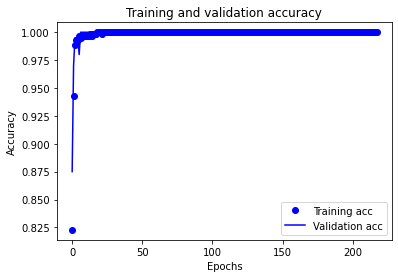

In [28]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(acc, 'bo', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

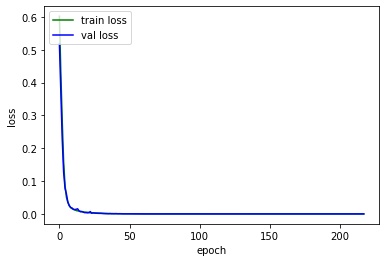

,label,y_predict
9,0,2.069889e-19
499,0,9.587232e-17
891,1,1.000000e+00
444,0,6.675882e-17
123,0,3.486414e-17
...,...,...
381,0,2.483746e-21
580,1,1.000000e+00
33,0,7.452822e-11
686,1,1.000000e+00


In [29]:
# 학습 시각화 함수
def learning_graph(hist):
    fig, loss_ax = plt.subplots()
    loss_ax.plot(hist.history['loss'],'g', label='train loss')
    loss_ax.plot(hist.history['val_loss'],'b', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()
    
learning_graph(hist)

# 실제값, 예측값 그래프
y_predict = model.predict(search_test_x) ####

# 에러율 - Root Mean Squared Error
# rmse = np.sqrt(mean_squared_error(y_predict, search_test_y))
# print('RMSE: ',rmse.round(2))

# r = explained_variance_score(search_test_y, y_predict)
# print('R-Square: ',r.round(2))

# fig, loss_ax = plt.subplots()
# loss_ax.bar(search_test_y)
# loss_ax.bar(y_predict)
# loss_ax.legend(loc='upper left')
# plt.show()

df = pd.DataFrame(search_test_y)
df.insert(1,'y_predict',y_predict)
df.rename(columns={0:'y_test'}, inplace=True)
df

# 동작구

In [30]:
dong_pred = pd.read_csv("dongjak_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)             #동작구 데이터 MinMax 전처리

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po   #전처리 된 데이터 보려고 만든 줄

,culture,build1,build2,build3,build4,build5,build6,build7
0,0.0,0.000000,0.000000,0.0,0.0,0.125,0.023121,0.00
1,0.0,0.214286,0.000000,0.0,1.0,0.125,0.075145,0.25
2,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.00
3,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.00
4,0.0,0.142857,0.000000,0.0,0.0,0.000,0.011561,0.25
...,...,...,...,...,...,...,...,...
131,0.0,0.500000,0.000000,0.0,0.0,0.250,0.283237,0.00
132,0.0,0.142857,0.045455,0.0,0.0,0.000,0.375723,0.00
133,0.0,0.142857,0.000000,0.0,0.0,0.000,0.115607,0.25
134,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.00


In [31]:
y_predict = model.predict(pred)    #동작구 데이터 적용
p = np.round(y_predict, 3)

In [32]:
dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

,culture,build1,build2,build3,build4,build5,build6,build7,result,result_round
0,0,0,0,0,0,1,4,0,5.648117e-17,0.000
1,0,3,0,0,16,1,13,1,8.930811e-01,0.893
2,0,0,0,0,0,0,0,0,2.634326e-16,0.000
3,0,0,0,0,0,0,0,0,2.634326e-16,0.000
4,0,2,0,0,0,0,2,1,3.995834e-18,0.000
...,...,...,...,...,...,...,...,...,...,...
131,0,7,0,0,0,2,49,0,2.117408e-19,0.000
132,0,2,1,0,0,0,65,0,3.417874e-16,0.000
133,0,2,0,0,0,0,20,1,1.193614e-17,0.000
134,0,0,0,0,0,0,0,0,2.634326e-16,0.000


In [33]:
# 추가할 데이터
dong_pred2 = pd.read_csv("dongjak_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

,charger,destination,population,consumer
0,0,232,453,1240
1,0,232,453,1240
2,0,232,453,1240
3,0,232,453,1240
4,0,232,453,1240
...,...,...,...,...
131,1,0,416,2139
132,0,0,416,2139
133,2,0,416,2139
134,0,0,475,2053


In [34]:
dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    if dong_pred['charger'][i]!=0:
        dong_pred['result'][i]=0

dong_pred

<ipython-input-34-d48fe6fd0154>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pred['result'][i]=0
C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,culture,build1,build2,build3,build4,build5,build6,build7,charger,destination,population,consumer,result_round,result
0,0,0,0,0,0,1,4,0,0,232,453,1240,0.000,5.648117e-17
1,0,3,0,0,16,1,13,1,0,232,453,1240,0.893,8.930811e-01
2,0,0,0,0,0,0,0,0,0,232,453,1240,0.000,2.634326e-16
3,0,0,0,0,0,0,0,0,0,232,453,1240,0.000,2.634326e-16
4,0,2,0,0,0,0,2,1,0,232,453,1240,0.000,3.995834e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0,7,0,0,0,2,49,0,1,0,416,2139,0.000,0.000000e+00
132,0,2,1,0,0,0,65,0,0,0,416,2139,0.000,3.417874e-16
133,0,2,0,0,0,0,20,1,2,0,416,2139,0.000,0.000000e+00
134,0,0,0,0,0,0,0,0,0,0,475,2053,0.000,2.634326e-16


In [35]:
dong_pred.to_csv('dongjak_result.csv', encoding='euc-kr')

# 동대문

In [36]:
dong_pred = pd.read_csv("dongdaemun_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("dongdaemun_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    if dong_pred['charger'][i]!=0:
        dong_pred['result'][i]=0

dong_pred.to_csv('dongdaemun_result.csv', encoding='euc-kr')

<ipython-input-36-3d75a193bd55>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pred['result'][i]=0


# 금천구

In [37]:
dong_pred = pd.read_csv("guemchon_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("guemchon_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]
for i in range(len(dong_pred)):
    if dong_pred['charger'][i]!=0:
        dong_pred['result'][i]=0

dong_pred.to_csv('guemchon_result.csv', encoding='euc-kr')

<ipython-input-37-c47f842149e5>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pred['result'][i]=0


# 광진구

In [38]:
dong_pred = pd.read_csv("gwangjin_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("gwangjin_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    if dong_pred['charger'][i]!=0:
        dong_pred['result'][i]=0

dong_pred.to_csv('gwangjin_result.csv', encoding='euc-kr')

<ipython-input-38-d67141de796e>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pred['result'][i]=0


# 중구

In [39]:
dong_pred = pd.read_csv("jung_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("jung_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    if dong_pred['charger'][i]!=0:
        dong_pred['result'][i]=0
        

dong_pred.to_csv('jung_result.csv', encoding='euc-kr')

<ipython-input-39-def148b8151f>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pred['result'][i]=0


# 성동구

In [40]:
dong_pred = pd.read_csv("sungdong_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("sungdong_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    if dong_pred['charger'][i]!=0:
        dong_pred['result'][i]=0

dong_pred.to_csv('sungdong_result.csv', encoding='euc-kr')

<ipython-input-40-6ec2d2be6204>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pred['result'][i]=0
